This data has two 'flaws':
  1. A hidden 'curve' (non-linearity) related to 'Experience'.
  2. 'Experience' and 'Training_Hours' are correlated (multicollinearity).

Plotting 'Salary' vs. 'Experience' to show the curve...


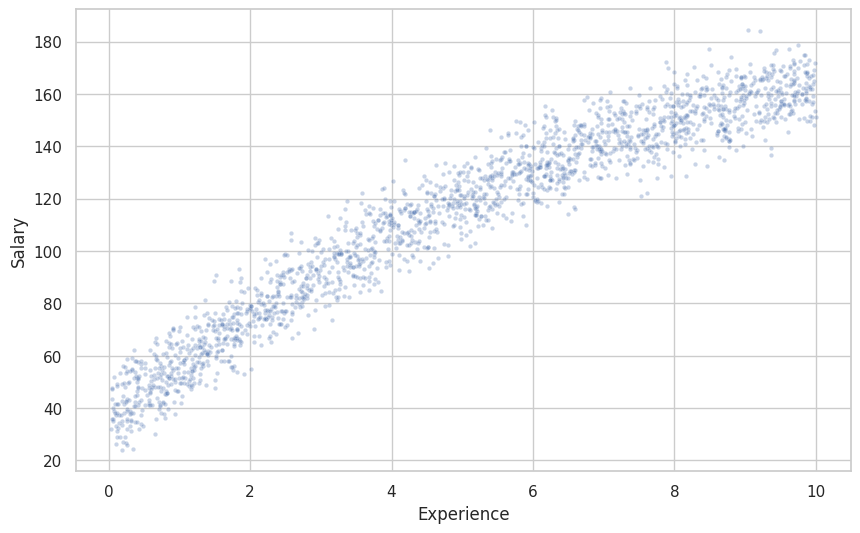

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df=pd.read_csv('/kaggle/input/salary-data/salary_data.csv')
# Set a nice style
sns.set_theme(style="whitegrid")
np.random.seed(42)




print("This data has two 'flaws':")
print("  1. A hidden 'curve' (non-linearity) related to 'Experience'.")
print("  2. 'Experience' and 'Training_Hours' are correlated (multicollinearity).")

# --- 4. Visualize the "Hidden Curve" ---
print("\nPlotting 'Salary' vs. 'Experience' to show the curve...")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Experience'], y=df['Salary'], alpha=0.3, s=10)
plt.xlabel("Experience")
plt.ylabel("Salary")
plt.show()



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, linear_reset
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- Settings ---
FILE_PATH = '/kaggle/input/salary-data/salary_data.csv' 
VALIDATION_SIZE = 0.2
RANDOM_SEED = 42

# Set a nice style
sns.set_theme(style="whitegrid")
np.random.seed(RANDOM_SEED)

print("--- Lesson: Analyzing the 'Textbook' Simulated Data ---")

# --- 1. Load Data ---
print(f"\n--- Step 1: Loading Data ---")
try:
    df = pd.read_csv(FILE_PATH)
    print(f"Successfully loaded {FILE_PATH}.")
except FileNotFoundError:
    print(f"Error: File not found. Please run 'simulate_perfect_data.py' first!")
    exit()

# --- 2. Preprocessing (MUCH simpler now!) ---
print("\n--- Step 2: Preprocessing ---")
# Data is already clean! No text, no log transforms needed.
y = df['Salary']
X = df.drop(columns=['Salary'])
print("Data is clean! Ready to split.")

# --- 3. Train/Test Split ---
print("\n--- Step 3: Creating Train/Validation Split ---")
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=VALIDATION_SIZE, random_state=RANDOM_SEED
)
print(f"Training on {len(X_train)} samples, validating on {len(X_val)} samples.")

# --- 4. Baseline MLR & Statsmodels Summary ---
print("\n--- Step 4: Baseline MLR & Statsmodels Summary ---")
scaler_sm = StandardScaler().fit(X_train)
X_train_scaled = scaler_sm.transform(X_train)
X_train_scaled_sm = sm.add_constant(pd.DataFrame(X_train_scaled, columns=X.columns), has_constant='add')

model_mlr_sm = sm.OLS(y_train.values, X_train_scaled_sm).fit()
print(model_mlr_sm.summary())

# --- 5. 5-Point Assumption Check (on Baseline MLR) ---
print("\n--- Step 5: 5-Point Assumption Check (on Baseline MLR) ---")
residuals = model_mlr_sm.resid

# 1. Linearity (RESET Test)
print("\n1. Linearity (RESET Test):")
reset = linear_reset(model_mlr_sm, power=2, use_f=True)
p_val = reset.pvalue
print(f"   p-value: {p_val:.3e}")
if p_val > 0.05: print("   -> ✅ PASS: Model seems linear.")
else: print("   -> ❌ FAIL: Model shows non-linearity. (This is expected!)")

# 2. Independence (Durbin-Watson)
print("\n2. Independence (Durbin-Watson):")
dw = durbin_watson(residuals)
print(f"   Statistic: {dw:.3f} (Want ~2.0)")
if 1.5 < dw < 2.5: print("   -> ✅ PASS: Residuals seem independent.")
else: print("   -> ❌ FAIL: Residuals show correlation.")

# 3. Homoscedasticity (Breusch-Pagan)
print("\n3. Homoscedasticity (Breusch-Pagan Test):")
bp = het_breuschpagan(residuals, X_train_scaled_sm)
p_val = bp[1]
print(f"   p-value: {p_val:.3f}")
if p_val > 0.05: print("   -> ✅ PASS: Spread is even (Homoscedastic).")
else: print("   -> ❌ FAIL: Spread is uneven (Heteroscedastic).")

# 4. Normality (Shapiro-Wilk)
print("\n4. Normality (Shapiro-Wilk Test):")
resids_sample = pd.Series(residuals).sample(min(5000, len(residuals)), random_state=RANDOM_SEED)
shapiro = stats.shapiro(resids_sample)
p_val = shapiro.pvalue
print(f"   p-value (on {len(resids_sample)} samples): {p_val:.3e}")
if p_val > 0.05: print("   -> ✅ PASS: Residuals look like a bell curve.")
else: print("   -> ❌ FAIL: Residuals are not a bell curve.")

# 5. Multicollinearity (VIF)
print("\n5. Multicollinearity (VIF):")
X_train_vif = sm.add_constant(X_train)
vif_df = pd.DataFrame()
vif_df["Variable"] = X_train_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
print(vif_df[vif_df['VIF'] > 5])
if (vif_df['VIF'] > 5).sum() > 1:
    print("   -> ❌ FAIL: High VIF scores detected! (This is also expected!)")
else:
    print("   -> ✅ PASS: VIF scores look acceptable.")

# --- 6. Polynomial (D2) Statsmodels Summary ---
print("\n--- Step 6: Polynomial (D2) Statsmodels Summary ---")
# Create D2 features, scale them, and add a constant
poly = PolynomialFeatures(degree=2, include_bias=False)
scaler_poly = StandardScaler()
X_train_poly = poly.fit_transform(X_train)
X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
X_train_poly_scaled_sm = sm.add_constant(X_train_poly_scaled)

model_poly_sm = sm.OLS(y_train.values, X_train_poly_scaled_sm).fit()
print(model_poly_sm.summary())
print("\n--- Interpretation ---")
print("Look for the p-values of the squared terms (e.g., x1^2).")
print("You should see that the p-value for the 'Experience^2' term is")
print("very small (p < 0.05). This is *proof* that the curve is real!")

# --- 7. Model Competition (The Final Story) ---
print("\n--- Step 7: Model Competition (The Final Story) ---")
# Get R2 for baseline MLR
X_val_scaled = scaler_sm.transform(X_val)
X_val_scaled_sm = sm.add_constant(pd.DataFrame(X_val_scaled, columns=X.columns), has_constant='add')
y_val_pred_mlr = model_mlr_sm.predict(X_val_scaled_sm)
r2_mlr = r2_score(y_val, y_val_pred_mlr)

# Define other models
pipe_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])
pipe_ridge = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=10.0))
])
pipe_lasso = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', Lasso(alpha=0.1, max_iter=2000)) # Alpha is smaller for Lasso
])

models_to_run = {
    "Polynomial (D2)": pipe_poly,
    "Ridge (D2)": pipe_ridge,
    "Lasso (D2)": pipe_lasso,
}

results = [{"Model": "MLR (Baseline)", "Val R2": r2_mlr}]
for name, model in models_to_run.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    r2_val = r2_score(y_val, y_val_pred)
    results.append({"Model": name, "Val R2": r2_val})

results_df = pd.DataFrame(results).set_index("Model")
print("\n--- 🏆 FINAL SCOREBOARD (R-squared) ---")
print(results_df.round(4))

# --- 8. Final Conclusion ---
print("\n--- Step 8: Final Conclusion ---")
print("1. 'MLR (Baseline)' was good, but our assumption checks *proved* it was flawed.")
print("2. 'Polynomial (D2)' got a *better* R2 because it found the hidden curve.")
print("3. 'Ridge' and 'Lasso' got the *best* R2 scores because they")
print("   found the curve *and* tamed the multicollinearity.")


--- Lesson: Analyzing the 'Textbook' Simulated Data ---

--- Step 1: Loading Data ---
Successfully loaded /kaggle/input/salary-data/salary_data.csv.

--- Step 2: Preprocessing ---
Data is clean! Ready to split.

--- Step 3: Creating Train/Validation Split ---
Training on 1600 samples, validating on 400 samples.

--- Step 4: Baseline MLR & Statsmodels Summary ---
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                 1.233e+04
Date:                Wed, 12 Nov 2025   Prob (F-statistic):               0.00
Time:                        08:59:04   Log-Likelihood:                -5557.7
No. Observations:                1600   AIC:                         1.112e+04
Df Residuals:                    1596   BIC:                         1.114e+04
Df 